In [1]:
import sympy as sp
import numpy as np
from scipy.integrate import nquad,quad
from tqdm import tqdm
import matplotlib.pyplot as plt

## 调用函数
以下两个函数用于计算矩阵A，尝试使用符号计算直接进行积分的求解，结果证实算法速度过慢。因此采用符号计算求得泰勒级数，而后转而使用数值计算求解，在积分区间附近可以达到比较好的效果。

In [2]:
def construct_A(n,basis_list,basis_point):
    matrix_A = sp.zeros(n+1)
    pos = []
    for p in range(0, n+1):
        for q in range(0, n+1):
            pos.append([p,q])
    for item in tqdm(pos):
        matrix_A = create_series(matrix_A,item,basis_list,basis_point)
    Lambda_diag = Lambda*np.matrix(np.diag(np.ones(n+1)))
    return Lambda_diag - matrix_A

In [3]:
def create_series(matrix_A,pos,basis_list,basis_point):
    t = basis_point[pos[0]]
    fi = basis_list[pos[1]]
    n_y = K.subs(x,t)*fi.subs(x,y)
    n_y_numpy = sp.lambdify(y,n_y,'numpy')
    #n_result = n_taylor_x.integrate((x,begin,end))
    n_result,_ = quad(n_y_numpy,begin,end)
    matrix_A[pos[0],pos[1]] = n_result
    return matrix_A

In [4]:
def generate_basis(method,begin,end,n):
    feature = 2*sp.pi/(end-begin)
    x = sp.Symbol('x')
    basis_list = []
    basis_point = []
    if method == 'linear':
        skip = (end-begin)/n
        for i in tqdm(range(n+1)):
            temp_begin = begin+(i-1)*skip
            temp_end = temp_begin+2*skip
            basis_list.append(sp.Piecewise((0, x < temp_begin),(0, x > temp_end),(1-sp.Abs(x-temp_begin-skip)/skip, True)))
            basis_point.append(begin+i*skip)  
    if method == 'trigo':
        skip = (end-begin)*2*sp.pi/(2*n+1)/feature
        for i in tqdm(range(2*n+1)):
            temp_begin = begin+i*skip
            basis_list.append(1/(2*n+1)*sp.sin(feature*(n+1/2)*(x-temp_begin))/sp.sin((x-temp_begin)/2*feature))
            basis_point.append(temp_begin)
    return basis_list,basis_point

### 封装配置法函数。

输入： $n$  基个数

输出： $result$  输出配置法求得的解

In [5]:
def Projection_method(n):
    basis_list,basis_point = generate_basis(method,begin,end,n)
    if method == 'linear':
        m = n
    elif method == 'trigo':
        m = 2*n
    A_n = construct_A(m,basis_list,basis_point)
    y_ = sp.zeros(m+1,1)
    for i in tqdm(range(m+1)):
        try:
            y_[i, 0] = g.evalf(subs={x:basis_point[i]})
        except Exception:
            y_[i, 0] = g.evalf(subs = {x:basis_point[i]+tolerance})
    A_n_acce = np.matrix(A_n).astype(np.float64)
    A_n_acce_inv = A_n_acce**(-1)
    A_n_inv = sp.Matrix(A_n_acce_inv)
    c = A_n_inv*y_
    result = 0
    for i in range(m+1):
        result = result + basis_list[i]*c[i,0]
    return result

## 主函数
本程序通过投影方法中的配置法求解第二类Fredholm方程。
$$\lambda f(x) - \int_a^{b} k(x,y)f(y) dy = g(x)$$

In [6]:
tolerance = 10**(-8)
x = sp.Symbol('x')
y = sp.Symbol('y')
Lambda = 1   
K = sp.sin(x*y)*x*y**2
begin = 0
end = 1
f_origin = 1+sp.exp(x)
# n = 15
method = 'linear'
start = 6
total = 5
span = 2

In [7]:
g = Lambda*f_origin-(K*f_origin.subs(x,y)).integrate((y,begin,end))
print(g)

-Piecewise((0, Eq(x, 0)), (-x*(4*x**6/(x**9 + 3*x**7 + 3*x**5 + x**3) + 6*x**2/(x**9 + 3*x**7 + 3*x**5 + x**3) + 2/(x**9 + 3*x**7 + 3*x**5 + x**3)) + x*(-E*x**8*cos(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) - x**8*cos(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + 2*x**7*sin(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + 3*E*x**7*sin(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) - x**6*cos(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + 4*E*x**6*cos(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) - 4*E*x**5*sin(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + 6*x**5*sin(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) - 3*E*x**4*cos(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + 3*x**4*cos(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + E*x**3*sin(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + 6*x**3*sin(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + 5*x**2*cos(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + 2*x*sin(x)/(x**9 + 3*x**7 + 3*x**5 + x**3) + 2*cos(x)/(x**9 + 3*x**7 + 3*x**5 + x**3)), True)) + exp(x) + 1


正在处理n=6的情况：


100%|██████████| 7/7 [00:00<00:00, 132.21it/s]


正在处理n=8的情况：


100%|██████████| 9/9 [00:00<00:00, 133.51it/s]


正在处理n=10的情况：


100%|██████████| 11/11 [00:00<00:00, 127.53it/s]


正在处理n=12的情况：


100%|██████████| 13/13 [00:00<00:00, 133.79it/s]


正在处理n=14的情况：


100%|██████████| 15/15 [00:00<00:00, 122.33it/s]


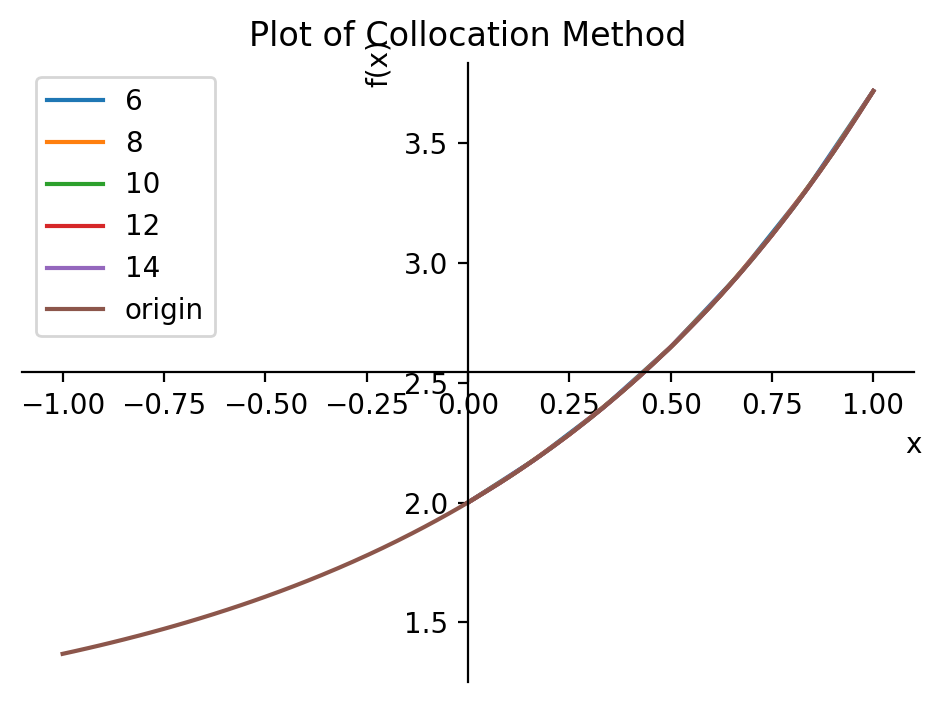

In [8]:
err_all = []
for i in range(start,start+total*span,span):
    print(f'正在处理n={i}的情况：')
    result = Projection_method(i)
    err_func = sp.lambdify(x,(result-f_origin)**2,'numpy')
    err = quad(err_func,begin,end,limit=max(i,100))[0]
    err_all.append(err)
    if i==start:
        p = sp.plotting.plot(result,(x,begin,end),label=f'{i}',show=False,legend=True,title = 'Plot of Collocation Method')
    else:
        p.append(sp.plotting.plot(result,(x,begin,end),label=f'{i}',show=False)[0])
p.append(sp.plotting.plot(f_origin,(x,begin+(begin-end),end),label=f'origin',show=False)[0])
p.show()

[2.5572575962118715e-05, 8.105761590790388e-06, 3.3228968321739305e-06, 1.603197870974056e-06, 8.655879010292493e-07]


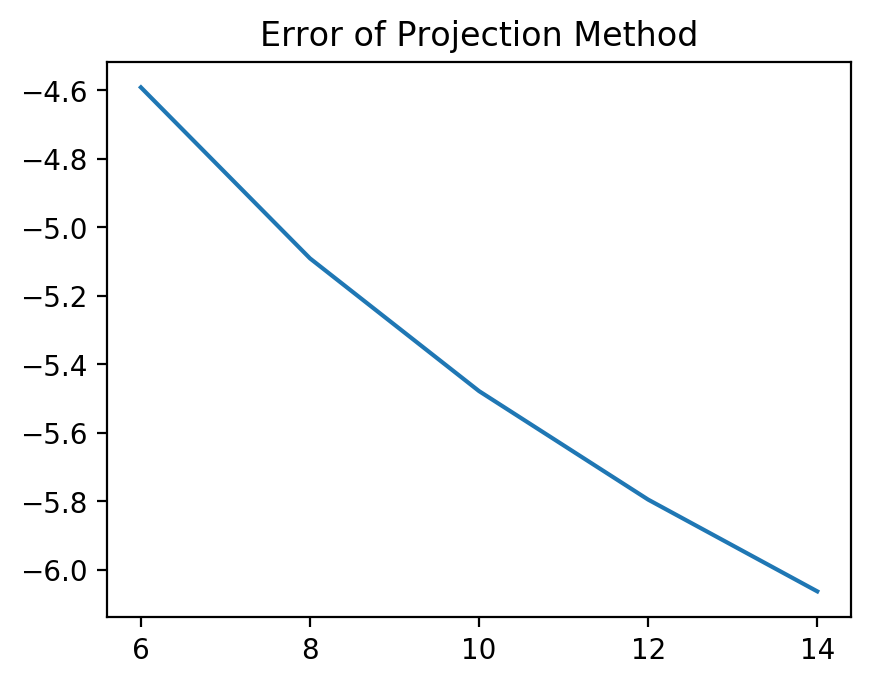

In [9]:
p_err = plt.plot(np.arange(start,start+total*span,span),[np.log10(float(x)) for x in err_all])
plt.title('Error of Projection Method')
print(err_all)